In [1]:



from roboflow import Roboflow
rf = Roboflow(api_key="iGVkU8jSwjfRVmfSXbhi")
project = rf.workspace("tesi-c4q2c").project("terrorist-flags-definitivo-segm")
version = project.version(9)
dataset = version.download("yolov11")
                
                

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
dataset.location

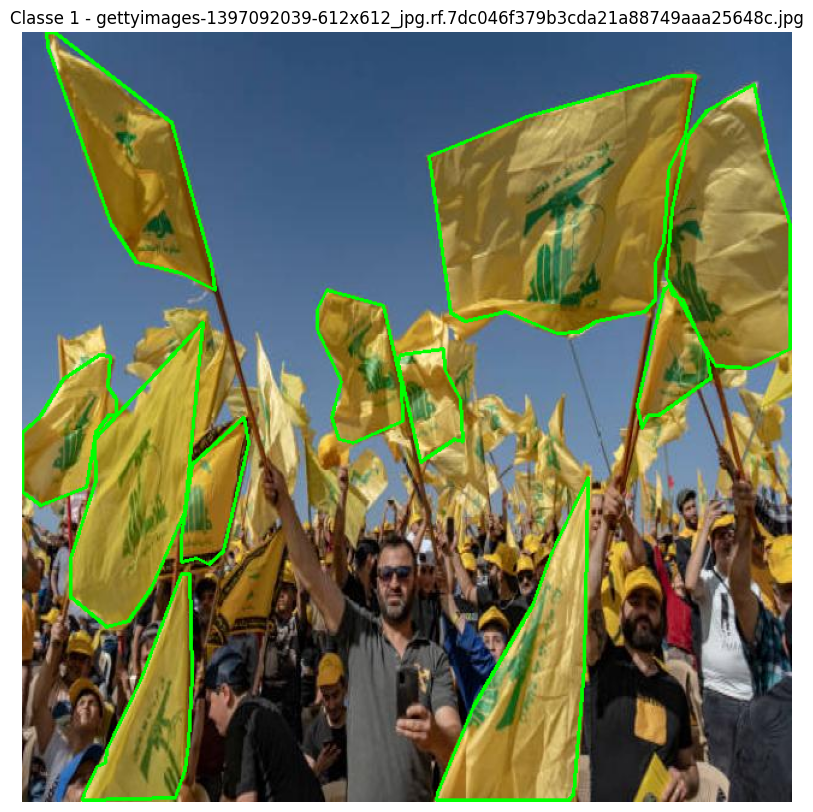

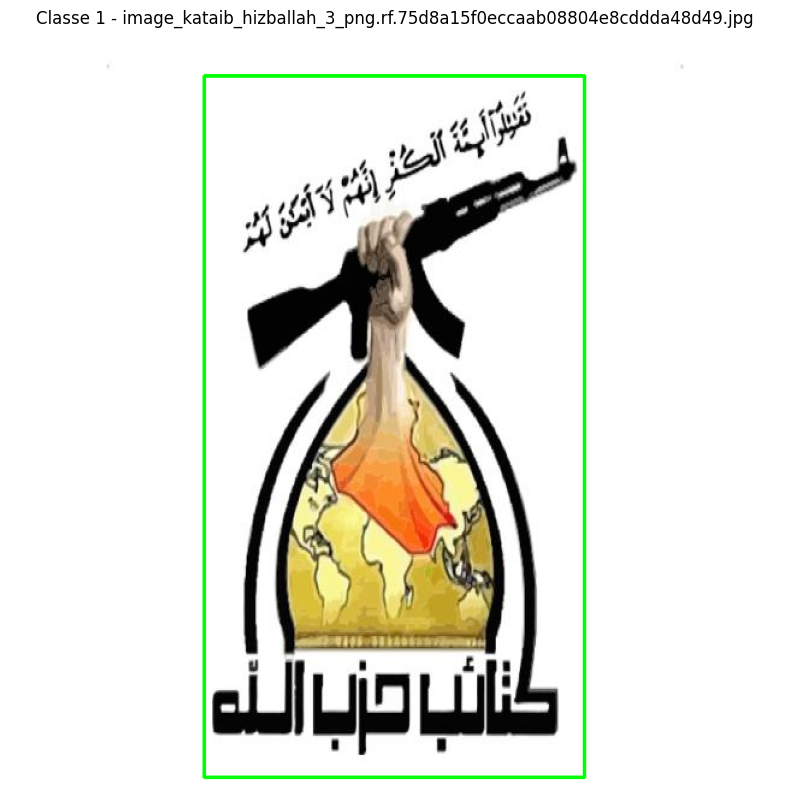

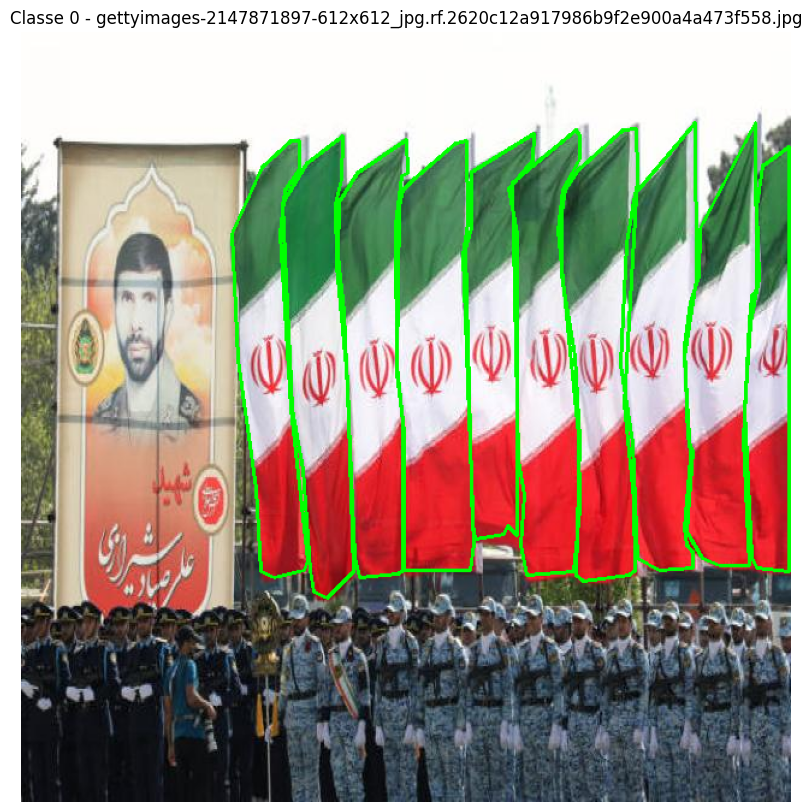

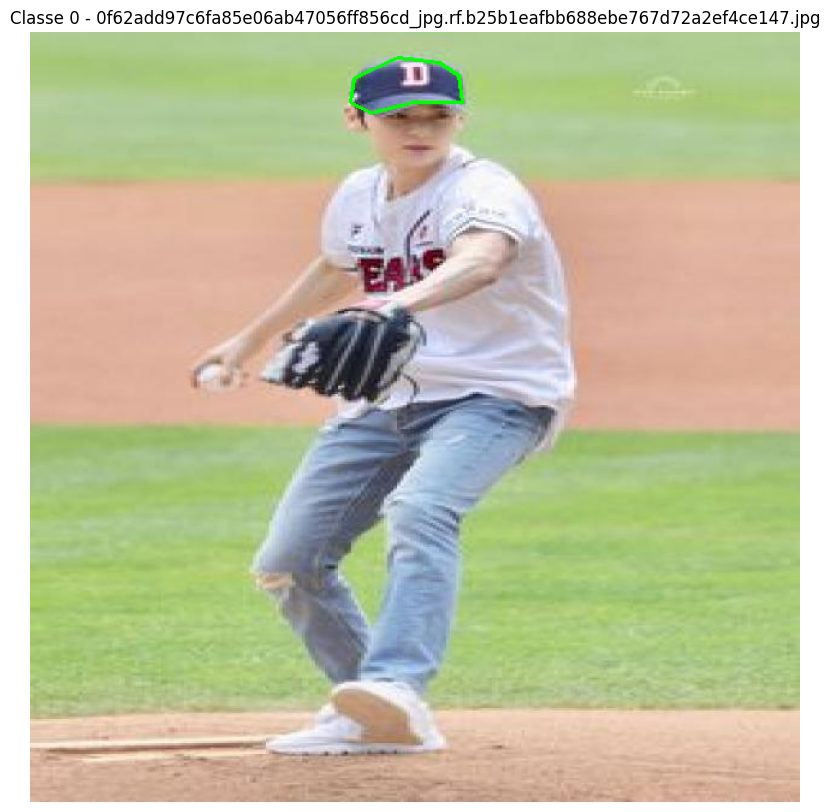

In [3]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Percorsi alle directory delle immagini e delle annotazioni
image_dir = f'{dataset.location}/train/images'
label_dir = f'{dataset.location}/train/labels'

# Ottieni la lista dei file di annotazione
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Dizionario per tracciare le immagini per classe
class_to_images = {}

# Popola il dizionario con le immagini che contengono ciascuna classe
for label_file in label_files:
    with open(os.path.join(label_dir, label_file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])
            if class_id not in class_to_images:
                class_to_images[class_id] = []
            image_name = label_file.replace('.txt', '.jpg')  # Assumendo che le immagini siano in formato .jpg
            class_to_images[class_id].append(image_name)

# Seleziona casualmente un paio di immagini per ogni classe
selected_images = {}
for class_id, images in class_to_images.items():
    selected_images[class_id] = random.sample(images, min(2, len(images)))

# Funzione per disegnare i poligoni sulle immagini
def draw_polygons(image, polygons):
    for polygon in polygons:
        pts = np.array(polygon, np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

# Visualizza le immagini con le maschere
for class_id, images in selected_images.items():
    for image_name in images:
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))
        
        # Carica l'immagine
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Leggi le annotazioni e prepara i poligoni
        polygons = []
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                cls_id = int(parts[0])
                if cls_id == class_id:
                    polygon = [(float(parts[i]), float(parts[i+1])) for i in range(1, len(parts), 2)]
                    # Converti le coordinate normalizzate in pixel
                    polygon = [(int(x * image.shape[1]), int(y * image.shape[0])) for x, y in polygon]
                    polygons.append(polygon)
        
        # Disegna i poligoni sull'immagine
        image_with_polygons = draw_polygons(image.copy(), polygons)
        
        # Visualizza l'immagine
        plt.figure(figsize=(10, 10))
        plt.imshow(image_with_polygons)
        plt.title(f'Classe {class_id} - {image_name}')
        plt.axis('off')
        plt.show()


**TRAINING CON AUGMENTATION DI YOLO**

In [ ]:
!yolo task=segment mode=train model='yolo11s-seg.pt' data={dataset.location}/data.yaml epochs=10 batch=16 plots=True cache='disk'  device=0 patience=10 deterministic=true degrees=10.0 translate=0.1 scale=0.5 shear=2.0 perspective=0.0 flipud=0.0 fliplr=0.5 hsv_h=0.015 hsv_s=0.5 hsv_v=0.4 mosaic=0.5 erasing=0.2

In [8]:
!yolo task=segment mode=val model=/home/poli/Tesi_Progetto/pipeline/terrorist_flags/weights/best.pt data={dataset.location}/data.yaml imgsz=640 plots=True device=0

Ultralytics 8.3.48 🚀 Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A5500, 24142MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,590 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /home/poli/Tesi_Progetto/dataset_bandiere/terrorist-flags-definiti
val: New cache created: /home/poli/Tesi_Progetto/dataset_bandiere/terrorist-flags-definitivo-segm-9/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        558        961      0.904      0.841       0.91      0.794      0.893      0.847      0.905      0.779
    NoTerrorist_symbol        207        483      0.921       0.81      0.904      0.786      0.917      0.822      0.903      0.766
      Terrorist_symbol        364        478      0.887      0.872      0.916      0.803       0.87      0.872      0.906      0.792
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://do

**TEST**

In [2]:
!yolo task=segment mode=val model=/home/poli/Tesi_Progetto/pipeline/terrorist_flags/weights/best.pt data={dataset.location}/data.yaml imgsz=640 plots=True device=0 split=test project=runs/ name=segment/test

Ultralytics 8.3.48 🚀 Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A5500, 24142MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,590 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /home/poli/Tesi_Progetto/dataset_bandiere/terrorist-flags-definiti
val: New cache created: /home/poli/Tesi_Progetto/dataset_bandiere/terrorist-flags-definitivo-segm-9/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        305        563      0.906      0.837      0.908      0.777      0.897       0.83        0.9       0.76
    NoTerrorist_symbol        113        265      0.944      0.857      0.925      0.809      0.935      0.849      0.914      0.788
      Terrorist_symbol        196        298      0.868      0.817      0.891      0.744      0.858      0.811      0.886      0.733
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/segment/test
💡 Learn more at https://do

**INFERENZA**

In [ ]:
!yolo task=segment mode=predict model=/home/poli/Tesi_Progetto/pipeline/terrorist_flags/weights/best.pt source=//home/poli/Tesi_Progetto/pipeline/images/images.jpeg imgsz=640 

In [3]:
import cv2

def process_and_visualize_image(image_path, detections, output_dir):
    """
    Processa un'immagine e disegna i bounding box sui rilevamenti.
    :param image_path: Percorso dell'immagine originale.
    :param detections: Lista di rilevamenti.
    :param output_dir: Directory di output per salvare l'immagine annotata.
    """
    # Carica l'immagine originale
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Immagine non trovata: {image_path}")

    # Colori per le categorie
    colors = {
        "Gun": (0, 255, 0),  # Verde
        "Grenade": (255, 0, 0),  # Blu
        "Bazooka": (0, 0, 255),  # Rosso
        "Knife": (255, 255, 0),  # Giallo
        "Pistol": (0, 255, 255),  # Ciano
        "Terrorist_symbol": (128, 0, 128),  # Viola
        "NoTerrorist_symbol": (0, 128, 128),  # Turchese
        "Terrorist_person": (128, 128, 0),  # Marrone
        "NoTerrorist_person": (128, 128, 128),  # Grigio
    }

    # Disegna i bounding box
    for det in detections:
        label = det["label"]
        confidence = det["confidence"]
        coordinates = det.get("coordinates", None)  # Coordinate del bounding box

        if coordinates:
            x1, y1, x2, y2 = map(int, coordinates)
            color = colors.get(label, (255, 255, 255))  # Bianco per label sconosciuti
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            text = f"{label} ({confidence:.2f})"
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Salva l'immagine annotata
    output_path = f"{output_dir}/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, image)
    print(f"Immagine annotata salvata in: {output_path}")


In [ ]:
# Directory di output per immagini annotate
ANNOTATED_DIR = "annotated_images/"
os.makedirs(ANNOTATED_DIR, exist_ok=True)

for filename in os.listdir(IMAGES_DIR):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(IMAGES_DIR, filename)
        print(f"Processando {filename}...")

        # Processa l'immagine e ottieni i rilevamenti
        detections = process_image(image_path)

        # Disegna i bounding box
        process_and_visualize_image(image_path, detections, ANNOTATED_DIR)
